In [8]:
using ControlSystems
# https://juliacontrol.github.io/ControlSystems.jl/latest/man/creating_systems/

## Set up the transfer functions

In [2]:
tf([1.0],[1,2,1])

TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
        1.0
-------------------
1.0s^2 + 2.0s + 1.0

Continuous-time transfer function model

## Zero pole gain representation

In [3]:
zpk([-1.0,1], [-5, -10], 2)

TransferFunction{Continuous, ControlSystems.SisoZpk{Float64, Float64}}
   (1.0s + 1.0)(1.0s - 1.0)
2.0-------------------------
   (1.0s + 5.0)(1.0s + 10.0)

Continuous-time transfer function model

## State Space Systems

In [6]:
using ControlSystems, StaticArrays
import ControlSystems.HeteroStateSpace
to_static(a::Number) = a
to_static(a::AbstractArray) = SMatrix{size(a)...}(a)
to_sized(a::Number) = a
to_sized(a::AbstractArray) = SizedArray{Tuple{size(a)...}}(a)
function HeteroStateSpace(A,B,C,D,Ts=0,f::F=to_static) where F
    HeteroStateSpace(f(A),f(B),f(C),f(D),Ts)
end
HeteroStateSpace(s,f) = HeteroStateSpace(s.A,s.B,s.C,s.D,s.timeevol,f)
ControlSystems._string_mat_with_headers(a::SizedArray) = ControlSystems._string_mat_with_headers(Matrix(a)); # Overload for printing purposes

In [7]:
sys = ss([-5 0; 0 -5],[2; 2],[3 3],[0])
HeteroStateSpace(sys, to_static)
HeteroStateSpace(sys, to_sized)

HeteroStateSpace{Continuous, SizedMatrix{2, 2, Int64, 2}, SizedMatrix{2, 1, Int64, 2}, SizedMatrix{1, 2, Int64, 2}, SizedMatrix{1, 1, Int64, 2}}
A = 
 -5   0
  0  -5
B = 
 2
 2
C = 
 3  3
D = 
 0

Continuous-time state-space model

## Iterative-Learning Control

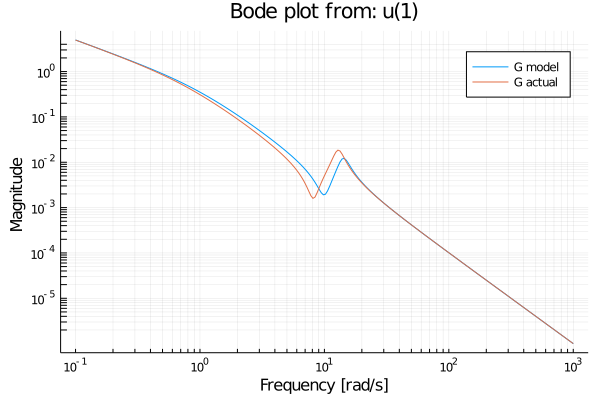

In [10]:
using ControlSystems, Plots

function double_mass_model(;
                Jm = 1,   # motor inertia
                Jl = 1,   # load inertia
                k  = 100, # stiffness
                c0 = 1,   # motor damping
                c1 = 1,   # transmission damping
                c2 = 1,   # load damping
)

    A = [
        0.0 1 0 0
        -k/Jm -(c1 + c0)/Jm k/Jm c1/Jm
        0 0 0 1
        k/Jl c1/Jl -k/Jl -(c1 + c2)/Jl
    ]
    B = [0, 1/Jm, 0, 0]
    C = [1 0 0 0]
    ss(A, B, C, 0)
end

G    = double_mass_model(Jl = 1)
Gact = double_mass_model(Jl = 1.5) # 50% more load than modeled

bodeplot([G, Gact], lab=["G model" "G actual"], plotphase=false)

Designing a PID Controller with a filter for the system

In [13]:
C  = pid(10, 1, 1, form = :series) * tf(1, [0.02, 1])
Ts = 0.02 # Sample time
Gc = c2d(feedback(G*C), Ts)       |> tf
Gcact = c2d(feedback(Gact*C), Ts) |> tf
plot(step(Gc, 10), title="Closed-loop step response", lab="model")
plot!(step(Gcact, 10), lab="actual")

LoadError: MethodError: no method matching pid(::Int64, ::Int64, ::Int64; form=:series)